Mounted at /content/drive
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}
Best RMSE (CV): 5.899298191070557
Tuned XGB RMSE: 4.983015586563773
Tuned XGB MAE: 3.3868608474731445
Tuned XGB R²: 0.9843107461929321


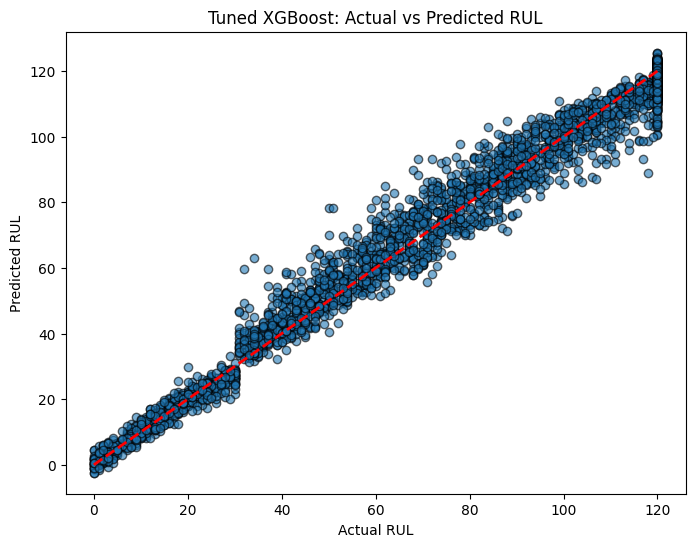

                               Feature    Importance
22   sensor_measurement_4_rolling_mean  57776.062500
17                              label1  34854.734375
30  sensor_measurement_11_rolling_mean  25690.964844
36  sensor_measurement_15_rolling_mean  14001.020508
42  sensor_measurement_21_rolling_mean  11614.195312
1                       time_in_cycles   4266.935547
28   sensor_measurement_9_rolling_mean   3841.643799
9                 sensor_measurement_9   2428.094971
0                          unit_number   2407.701172
38  sensor_measurement_17_rolling_mean   1751.364502
18   sensor_measurement_2_rolling_mean   1735.535400
40  sensor_measurement_20_rolling_mean   1489.387207
24   sensor_measurement_7_rolling_mean   1450.353638
32  sensor_measurement_12_rolling_mean   1423.052856
20   sensor_measurement_3_rolling_mean   1345.403198
34  sensor_measurement_13_rolling_mean   1125.139038
26   sensor_measurement_8_rolling_mean    887.025574
25    sensor_measurement_7_rolling_std    387.

<Figure size 1000x800 with 0 Axes>

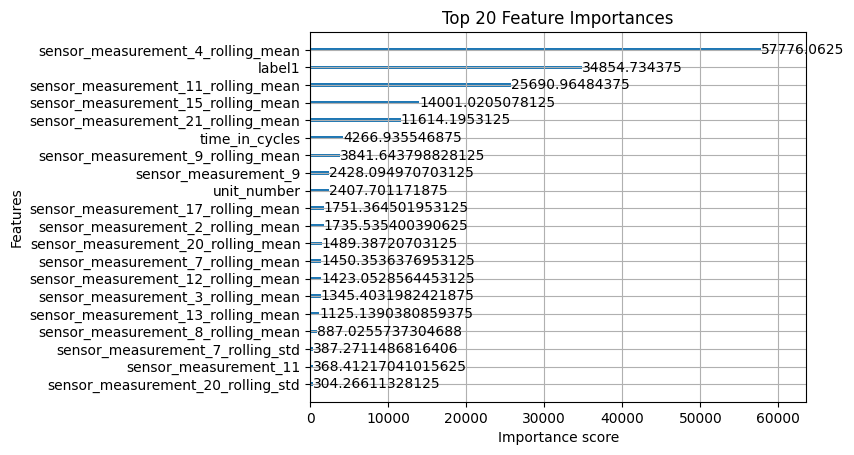

Predicted vs Actual plot saved
Feature importance plot saved
Tuned XGB model saved


In [ ]:
### -------------------------------------------------------------------------- ###
# --- XGB Tuned Model ---
# ---------------------------------------------------------------------------- ###

from google.colab import drive
drive.mount('/content/drive')

# --- 1. Imports ---
# --------------------------------------------- #
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV



# --- 2. Load Data
# ------------------------------------------------ #
file_path = '/content/drive/MyDrive/predictive_maintenance/processed_train_FD001.csv'
df = pd.read_csv(file_path)

# -- 3. Add RUL
# ------------------------------------------------- #
df['RUL'] = df.groupby('unit_number')['time_in_cycles'].transform(lambda x: x.max() - x)
df['RUL'] = df['RUL'].clip(upper=120)

# Features + Target
X = df.drop(columns=['RUL'])
y = df['RUL']

# ---4. Train-test split
#
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# --- Define parameter grid
# --------------------------------------------------- #
param_grid = {
    'n_estimators' : [100, 200, 300, 500],
    'max_depth' : [3, 5, 7, 10],
    'learning_rate' : [0.01, 0.05, 0.1, 0.2],
    'subsample' : [0.6, 0.8, 1.0],
    'colsample_bytree' : [0.6, 0.8, 1.0],
    'gamma' : [0, 0.1, 0.2, 0.3]
}

# --- 5. Initialize the model
# ------------------------------------------------------- #
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Setup the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,                # number of random combinations to try
    scoring ='neg_root_mean_squared_error', # optimize for RMSE
    cv=3,                # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run the search
random_search.fit(X_train, y_train)

# Print the best parameters & performance
print("Best Parameters:" , random_search.best_params_)
print("Best RMSE (CV):", -random_search.best_score_)

# --- 6. Evaluate tuned model
# -------------------------------------------------------------- #
best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

print("Tuned XGB RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_tuned)))
print("Tuned XGB MAE:", mean_absolute_error(y_test, y_pred_tuned))
print("Tuned XGB R²:", r2_score(y_test, y_pred_tuned))

# --- 7. Plot Actual vs Predicted for tuned XGB
# ------------------------------------------------------------- #
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_tuned, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Tuned XGBoost: Actual vs Predicted RUL')
plt.savefig("/content/drive/MyDrive/predictive_maintenance/xgb_pred_vs_actual.png", dpi=300)
plt.show()

# --- 8. Feature Importance Analysis for Tuned XGB Model
# ------------------------------------------------------------------ #
importance = best_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

print(importance_df.head(20))

# Plot for Feature Importance of Tuned XGBoost model
plt.figure(figsize=(10,8))
plot_importance(best_model, importance_type='gain', max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.savefig("/content/drive/MyDrive/predictive_maintenance/xgb_feature_importance.png", dpi=300)
plt.show()

# --- 9. Save Day 06 Results and Plots
# --------------------------------------------------------------------- #
print("Predicted vs Actual plot saved")
print("Feature importance plot saved")

import joblib
joblib.dump(best_model, "/content/drive/MyDrive/predictive_maintenance/best_xgb_model.pkl")
print("Tuned XGB model saved")
